# Image Classification Model Deployment - CNN

**Raynold Panji Zulfiandi**

> Emotion Detection

> Dataset: https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer

In [1]:
# %tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

2.6.4


In [2]:
# cek penggunaan GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


2022-10-14 06:22:39.902207: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-14 06:22:39.979676: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-14 06:22:40.100823: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-14 06:22:40.101599: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [ ]:
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# if len(physical_devices) > 0:
#     tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Data Preparation

### Download Dataset (Google collbs)

In [6]:
!pip install -q kaggle
from google.colab import files 

# upload kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"raynoldpanji","key":"18f3f6dd72e3f4bcc0dbc0912582615b"}'}

In [7]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [8]:
!kaggle datasets download -d ananthu017/emotion-detection-fer


 98% 64.0M/65.2M [00:03<00:00, 27.9MB/s]

100% 65.2M/65.2M [00:03<00:00, 22.2MB/s]


In [9]:
# !rm -rf datasets
!ls 

emotion-detection-fer.zip  kaggle.json	sample_data


In [10]:
!mkdir datasets
!unzip -q emotion-detection-fer.zip -d datasets
!ls datasets

test  train


### Download Datasets (kaggle notebook)

In [3]:
# !rm -rf datasets
!ls -al

total 16
drwxr-xr-x 3 root root 4096 Oct 14 06:22 .
drwxr-xr-x 5 root root 4096 Oct 14 06:22 ..
drwxr-xr-x 2 root root 4096 Oct 14 06:22 .virtual_documents
---------- 1 root root  263 Oct 14 06:22 __notebook_source__.ipynb


In [4]:
!mkdir ./datasets
!cp -r ../input/emotion-detection-fer/* ./datasets
!ls -al datasets

total 16
drwxr-xr-x 4 root root 4096 Oct 14 06:24 .
drwxr-xr-x 4 root root 4096 Oct 14 06:23 ..
drwxr-xr-x 9 root root 4096 Oct 14 06:24 test
drwxr-xr-x 9 root root 4096 Oct 14 06:26 train


In [5]:
!chmod 777 ./datasets/train
!chmod 777 ./datasets/test

!ls datasets/test

angry  disgusted  fearful  happy  neutral  sad	surprised


# Data Cleansing

In [6]:
import os

TRAINING_DIR = 'datasets/train/'
VALIDATION_DIR = 'datasets/test/'

os.listdir(TRAINING_DIR), os.listdir(VALIDATION_DIR)

(['angry', 'surprised', 'neutral', 'sad', 'fearful', 'happy', 'disgusted'],
 ['angry', 'surprised', 'neutral', 'sad', 'fearful', 'happy', 'disgusted'])

In [7]:
## cek jumlah dataset
def jum_data():
  train = []
  val = []
  lists = os.listdir(TRAINING_DIR)
  for cls in lists:
    train.append(len(os.listdir(os.path.join(TRAINING_DIR, cls))))
  for cls in lists:
    val.append(len(os.listdir(os.path.join(VALIDATION_DIR, cls))))
  return train, val, lists

def cek_data():
  chs = []
  train, val, lists = jum_data()
  
  msg="\n======================================"
  for i, cls in enumerate(lists):
    tot = train[i]+val[i]
    ch = round(tot*0.8)
    chs.append(ch-train[i])
    percen = ": "+str(80)+"% dari total ✓✓" if (ch==train[i]) else "-"
    msg=msg+f"\ntotal {cls}\t: {train[i]} ===> {ch} {percen}"
  msg=msg+"\ntotal : "+str(sum(train))
  
  msg=msg+"\n======================================"
  for i, cls in enumerate(lists):
    tot = train[i]+val[i]
    percen = ": "+str(20)+"% dari total ✓✓" if (round(tot*0.2)==val[i]) else "-"
    msg=msg+f"\ntotal {cls}\t: {val[i]} ===> {round(tot*0.2)} {percen}"
  msg=msg+"\ntotal : "+str(sum(val))

  msg=msg+"\n======================================"
  return msg, chs

print(cek_data()[0])
print(cek_data()[1])


total angry	: 3995 ===> 3962 -
total surprised	: 3171 ===> 3202 -
total neutral	: 4965 ===> 4958 -
total sad	: 4830 ===> 4862 -
total fearful	: 4097 ===> 4097 : 80% dari total ✓✓
total happy	: 7215 ===> 7191 -
total disgusted	: 436 ===> 438 -
total : 28709
total angry	: 958 ===> 991 -
total surprised	: 831 ===> 800 -
total neutral	: 1233 ===> 1240 -
total sad	: 1247 ===> 1215 -
total fearful	: 1024 ===> 1024 : 20% dari total ✓✓
total happy	: 1774 ===> 1798 -
total disgusted	: 111 ===> 109 -
total : 7178
[-33, 31, -7, 32, 0, -24, 2]


In [8]:
## hapus folder disgusted
import shutil
shutil.rmtree(os.path.join(TRAINING_DIR, 'disgusted') )
shutil.rmtree(os.path.join(VALIDATION_DIR, 'disgusted'))

os.listdir(TRAINING_DIR), os.listdir(VALIDATION_DIR)
print(cek_data()[0])
print(cek_data()[1])


total angry	: 3995 ===> 3962 -
total surprised	: 3171 ===> 3202 -
total neutral	: 4965 ===> 4958 -
total sad	: 4830 ===> 4862 -
total fearful	: 4097 ===> 4097 : 80% dari total ✓✓
total happy	: 7215 ===> 7191 -
total : 28273
total angry	: 958 ===> 991 -
total surprised	: 831 ===> 800 -
total neutral	: 1233 ===> 1240 -
total sad	: 1247 ===> 1215 -
total fearful	: 1024 ===> 1024 : 20% dari total ✓✓
total happy	: 1774 ===> 1798 -
total : 7067
[-33, 31, -7, 32, 0, -24]


In [9]:
## pindahkan train test gambar agar sesuai kriteria 80/20

import random 

for i, dir in enumerate(jum_data()[2]):
  source = None
  dest = None

  if (cek_data()[1][i])<0:
    source = os.path.join(TRAINING_DIR, dir)
    dest = os.path.join(VALIDATION_DIR, dir)
  elif cek_data()[1][i]>0:
    source = os.path.join(VALIDATION_DIR, dir)
    dest = os.path.join(TRAINING_DIR, dir)
  
  if source==None:
    continue
  files = os.listdir(source)

  for file_name in random.sample(files, abs(cek_data()[1][i])):
    shutil.move(os.path.join(source, file_name), os.path.join(dest, "mov_"+file_name))
    print(f"\r{file_name} moved", end=" ")
  print("\n"+source+" ==> "+dest+" ✓✓")

im1360.png moved 
datasets/train/angry ==> datasets/test/angry ✓✓
im45.png moved  
datasets/test/surprised ==> datasets/train/surprised ✓✓
im3113.png moved 
datasets/train/neutral ==> datasets/test/neutral ✓✓
im317.png moved  
datasets/test/sad ==> datasets/train/sad ✓✓
im3305.png moved 
datasets/train/happy ==> datasets/test/happy ✓✓


In [10]:
print(cek_data()[0])
print(cek_data()[1])


total angry	: 3962 ===> 3962 : 80% dari total ✓✓
total surprised	: 3202 ===> 3202 : 80% dari total ✓✓
total neutral	: 4958 ===> 4958 : 80% dari total ✓✓
total sad	: 4862 ===> 4862 : 80% dari total ✓✓
total fearful	: 4097 ===> 4097 : 80% dari total ✓✓
total happy	: 7191 ===> 7191 : 80% dari total ✓✓
total : 28272
total angry	: 991 ===> 991 : 20% dari total ✓✓
total surprised	: 800 ===> 800 : 20% dari total ✓✓
total neutral	: 1240 ===> 1240 : 20% dari total ✓✓
total sad	: 1215 ===> 1215 : 20% dari total ✓✓
total fearful	: 1024 ===> 1024 : 20% dari total ✓✓
total happy	: 1798 ===> 1798 : 20% dari total ✓✓
total : 7068
[0, 0, 0, 0, 0, 0]


In [11]:
## Undersampling class happy

avg_undersampling = (sum(jum_data()[0]) / len(jum_data()[0])) / 7191  # persentase 0.6553

train_happy = 7191 - round(7191 * avg_undersampling)  # total train - 65,53% dari total train data: 4712
val_happy = 1798 - round(1798 * avg_undersampling)    # total val - 65,53% dari total val data: 1178

train_dir = os.path.join(TRAINING_DIR, 'happy')
val_dir = os.path.join(VALIDATION_DIR, 'happy')

for i, file_name in enumerate(random.sample(os.listdir(train_dir), train_happy)):
  os.remove(os.path.join(train_dir, file_name))
print(str(train_happy)+" files removed ")

for i, file_name in enumerate(random.sample(os.listdir(val_dir), val_happy)):
  os.remove(os.path.join(val_dir, file_name))
print(str(val_happy)+" files removed ")

2479 files removed 
620 files removed 


In [12]:
print(cek_data()[0])
print(cek_data()[1])


total angry	: 3962 ===> 3962 : 80% dari total ✓✓
total surprised	: 3202 ===> 3202 : 80% dari total ✓✓
total neutral	: 4958 ===> 4958 : 80% dari total ✓✓
total sad	: 4862 ===> 4862 : 80% dari total ✓✓
total fearful	: 4097 ===> 4097 : 80% dari total ✓✓
total happy	: 4712 ===> 4712 : 80% dari total ✓✓
total : 25793
total angry	: 991 ===> 991 : 20% dari total ✓✓
total surprised	: 800 ===> 800 : 20% dari total ✓✓
total neutral	: 1240 ===> 1240 : 20% dari total ✓✓
total sad	: 1215 ===> 1215 : 20% dari total ✓✓
total fearful	: 1024 ===> 1024 : 20% dari total ✓✓
total happy	: 1178 ===> 1178 : 20% dari total ✓✓
total : 6448
[0, 0, 0, 0, 0, 0]


In [13]:
## Undersampling class sad, happy, dan neutral
train_sampling = ((4958 + 4862 + 4712) // 3) - (3962 + 3202 + 4097) // 3  # rata2 data train yg besar - rata2 train yg kecil: 1091
val_sampling = ((1240 + 1215 + 1178) // 3) - (991 + 800 + 1024) // 3    # rata2 data val yg besar - rata2 val yg kecil: 273

# remove sebagian data pada data happy, neutral, dan sad
for u_dir in ['happy', 'neutral', 'sad']:
  train_dir = os.path.join(TRAINING_DIR, u_dir)
  val_dir = os.path.join(VALIDATION_DIR, u_dir)
  for i, file_name in enumerate(random.sample(os.listdir(train_dir), round(train_sampling))):
    os.remove(os.path.join(train_dir, file_name))
    continue
  print(f"{i+1} train {u_dir} files removed ")
  for i, file_name in enumerate(random.sample(os.listdir(val_dir), round(val_sampling))):
    os.remove(os.path.join(val_dir, file_name))
    continue
  print(f"{i+1} val {u_dir} files removed ")

1091 train happy files removed 
273 val happy files removed 
1091 train neutral files removed 
273 val neutral files removed 
1091 train sad files removed 
273 val sad files removed 


In [14]:
print(cek_data()[0])
print(cek_data()[1])


total angry	: 3962 ===> 3962 : 80% dari total ✓✓
total surprised	: 3202 ===> 3202 : 80% dari total ✓✓
total neutral	: 3867 ===> 3867 : 80% dari total ✓✓
total sad	: 3771 ===> 3770 -
total fearful	: 4097 ===> 4097 : 80% dari total ✓✓
total happy	: 3621 ===> 3621 : 80% dari total ✓✓
total : 22520
total angry	: 991 ===> 991 : 20% dari total ✓✓
total surprised	: 800 ===> 800 : 20% dari total ✓✓
total neutral	: 967 ===> 967 : 20% dari total ✓✓
total sad	: 942 ===> 943 -
total fearful	: 1024 ===> 1024 : 20% dari total ✓✓
total happy	: 905 ===> 905 : 20% dari total ✓✓
total : 5629
[0, 0, 0, -1, 0, 0]


In [15]:
source = os.path.join(TRAINING_DIR, 'sad')
dest = os.path.join(VALIDATION_DIR, 'sad')
file = random.sample(os.listdir(source), 1)[0]

shutil.move(os.path.join(source, file), os.path.join(dest, "mov_"+file))
# print(os.path.join(source, file))

print(cek_data()[0])
print(cek_data()[1])


total angry	: 3962 ===> 3962 : 80% dari total ✓✓
total surprised	: 3202 ===> 3202 : 80% dari total ✓✓
total neutral	: 3867 ===> 3867 : 80% dari total ✓✓
total sad	: 3770 ===> 3770 : 80% dari total ✓✓
total fearful	: 4097 ===> 4097 : 80% dari total ✓✓
total happy	: 3621 ===> 3621 : 80% dari total ✓✓
total : 22519
total angry	: 991 ===> 991 : 20% dari total ✓✓
total surprised	: 800 ===> 800 : 20% dari total ✓✓
total neutral	: 967 ===> 967 : 20% dari total ✓✓
total sad	: 943 ===> 943 : 20% dari total ✓✓
total fearful	: 1024 ===> 1024 : 20% dari total ✓✓
total happy	: 905 ===> 905 : 20% dari total ✓✓
total : 5630
[0, 0, 0, 0, 0, 0]


In [17]:
## backup datasets
!mkdir ./datasets/backup
!cp -r ./datasets/{train,test} ./datasets/backup
!ls -al ./datasets/backup

total 16
drwxr-xr-x 4 root root 4096 Oct 14 06:26 .
drwxr-xr-x 5 root root 4096 Oct 14 06:26 ..
drwxr-xr-x 8 root root 4096 Oct 14 06:26 test
drwxr-xr-x 8 root root 4096 Oct 14 06:26 train


In [18]:
## hapus class surprised dan fearful
shutil.rmtree(os.path.join(TRAINING_DIR, 'angry') )
shutil.rmtree(os.path.join(VALIDATION_DIR, 'angry'))

shutil.rmtree(os.path.join(TRAINING_DIR, 'neutral'))
shutil.rmtree(os.path.join(VALIDATION_DIR, 'neutral'))

shutil.rmtree(os.path.join(TRAINING_DIR, 'fearful'))
shutil.rmtree(os.path.join(VALIDATION_DIR, 'fearful'))

print(cek_data()[0])
print(cek_data()[1])


total surprised	: 3202 ===> 3202 : 80% dari total ✓✓
total sad	: 3770 ===> 3770 : 80% dari total ✓✓
total happy	: 3621 ===> 3621 : 80% dari total ✓✓
total : 10593
total surprised	: 800 ===> 800 : 20% dari total ✓✓
total sad	: 943 ===> 943 : 20% dari total ✓✓
total happy	: 905 ===> 905 : 20% dari total ✓✓
total : 2648
[0, 0, 0]


# Data Preprocessing

In [19]:
## Augmentasi data

from keras.preprocessing.image import ImageDataGenerator
training_datagen = ImageDataGenerator(
    rescale = 1./255.,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip = True,
    fill_mode='nearest',
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,  
)

img_size = 128
batch_size = 45

train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR, 
    class_mode='categorical', 
    target_size=(img_size, img_size), 
    batch_size=batch_size,
#     color_mode='grayscale'
)

validation_generator = validation_datagen.flow_from_directory(      
    VALIDATION_DIR,    
    class_mode='categorical',
    target_size=(img_size, img_size),
    batch_size=batch_size,
#     color_mode='grayscale'
)

Found 10593 images belonging to 3 classes.
Found 2648 images belonging to 3 classes.


In [20]:
train_generator.class_indices

{'happy': 0, 'sad': 1, 'surprised': 2}

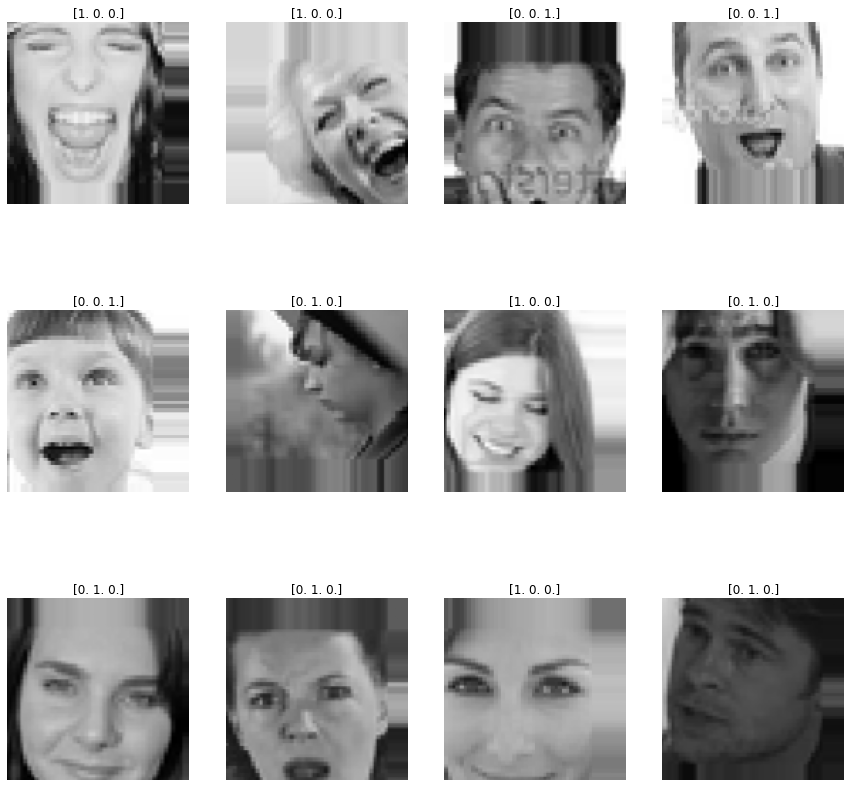

In [21]:
## Plot gambar

import numpy as np
import matplotlib.pylab as plt
import random 

plt.figure(figsize=[15,15])
for i in range(12):
    x, y = random.choice(train_generator)
    plt.subplot(3, 4, i+1)
    for im, lb in zip(x, y):
        plt.title(str(lb))
#         plt.imshow(im.reshape(img_size, img_size))
        plt.imshow(im)
        plt.axis('off')
plt.show()

# Training

In [22]:
# conv_base = tf.keras.applications.ResNet152V2(include_top=False, input_shape=(img_size, img_size, 3), weights='imagenet')
conv_base = tf.keras.applications.InceptionResNetV2(include_top=False, input_shape=(img_size, img_size, 3), weights='imagenet')

conv_base.summary()

2022-10-14 06:35:00.546258: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-14 06:35:00.547098: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-14 06:35:00.547768: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-14 06:35:00.548669: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-14 06:35:00.549368: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

219070464/219055592 [==============================] - 3s 0us/step
Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 32)   0           batch_normalization[0][0]        
_____________

In [23]:
## Frezze sebagian layer
# for layer in conv_base.layers[:-2]:
#   layer.trainable = False


## build architecture
num_cls = len(train_generator.class_indices)

model = tf.keras.models.Sequential([
  conv_base,

#   tf.keras.layers.Conv2D(512,(3,3), padding="same", activation="relu"),
  tf.keras.layers.Conv2D(512,(2,2), padding="same", activation="relu"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2,2),
  
  tf.keras.layers.Flatten(),
  
#   tf.keras.layers.Dense(512, activation="relu", use_bias=True, kernel_regularizer=tf.keras.regularizers.l2(l=0.01)),
  tf.keras.layers.Dense(265, activation="relu", use_bias=True),
  tf.keras.layers.Dropout(0.5),
    
  tf.keras.layers.Dense(128, activation="relu", use_bias=True),
  tf.keras.layers.Dropout(0.5),

  tf.keras.layers.Dense(64, activation="relu", use_bias=True),
  tf.keras.layers.Dropout(0.5),
  
  tf.keras.layers.Dense(num_cls, activation="softmax")
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 2, 2, 1536)        54336736  
_________________________________________________________________
conv2d_203 (Conv2D)          (None, 2, 2, 512)         3146240   
_________________________________________________________________
batch_normalization_203 (Bat (None, 2, 2, 512)         2048      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 1, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 265)               135945    
_________________________________________________________________
dropout (Dropout)            (None, 265)               0

In [24]:
## define callbacks

early_stopping = tf.keras.callbacks.EarlyStopping(
  monitor = "val_accuracy",
  patience = 10,
  verbose = 0,
  mode = "auto",
  restore_best_weights=True
)

callbacks = [early_stopping]

In [25]:
## compile model
epochs = 100
lr = 0.001
decay_rate = lr / epochs
momentum=0.9

opt_adam = tf.optimizers.Adam(learning_rate=lr)
opt_rms = tf.optimizers.RMSprop(learning_rate=lr)
opt_sgd_par = tf.optimizers.SGD(learning_rate=lr, decay=decay_rate, momentum=momentum)
opt_sgd = tf.optimizers.SGD(learning_rate=lr)

model.compile(
  loss = 'categorical_crossentropy',
  optimizer = opt_sgd_par,
  metrics = ['accuracy']
)


## Train model

STEP_PER_EPOCH = train_generator.n // train_generator.batch_size
VALIDATION_STEPS = validation_generator.n // validation_generator.batch_size

with tf.device(device_name):
  history = model.fit(
      train_generator,
      steps_per_epoch = STEP_PER_EPOCH,
      epochs = epochs,
      validation_data = validation_generator,
      validation_steps = VALIDATION_STEPS,
      verbose = 1,
      callbacks = callbacks
  )

2022-10-14 06:35:48.197628: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-10-14 06:36:04.623486: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


235/235 [==============================] - 89s 282ms/step - loss: 1.1705 - accuracy: 0.4646 - val_loss: 0.8695 - val_accuracy: 0.6188
Epoch 2/100
235/235 [==============================] - 63s 268ms/step - loss: 0.8920 - accuracy: 0.5691 - val_loss: 0.7573 - val_accuracy: 0.6912
Epoch 3/100
235/235 [==============================] - 63s 267ms/step - loss: 0.7951 - accuracy: 0.6430 - val_loss: 0.6672 - val_accuracy: 0.7161
Epoch 4/100
235/235 [==============================] - 63s 267ms/step - loss: 0.7245 - accuracy: 0.7102 - val_loss: 0.5895 - val_accuracy: 0.7785
Epoch 5/100
235/235 [==============================] - 64s 273ms/step - loss: 0.6591 - accuracy: 0.7486 - val_loss: 0.5825 - val_accuracy: 0.7670
Epoch 6/100
235/235 [==============================] - 63s 268ms/step - loss: 0.6241 - accuracy: 0.7625 - val_loss: 0.5172 - val_accuracy: 0.8077
Epoch 7/100
235/235 [==============================] - 64s 273ms/step - loss: 0.5831 - accuracy: 0.7850 - val_loss: 0.4898 - val_accurac

In [27]:
## model evaluate

loss, acc = model.evaluate(validation_generator)
print(f"valid accuracy: {acc} \nvalid loss: {loss}")

59/59 [==============================] - 5s 76ms/step - loss: 0.3811 - accuracy: 0.8943
valid accuracy: 0.8942598104476929 
valid loss: 0.3811184763908386


# Evaluation Model

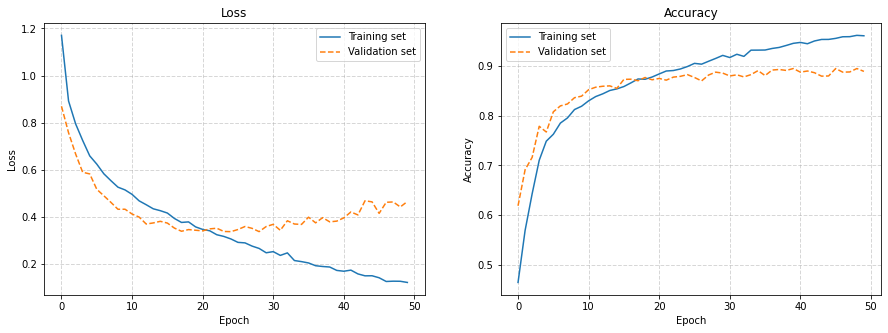

In [28]:
## Plot accuracy dan Loss

loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss, label='Training set')
plt.plot(val_loss, label='Validation set', linestyle='--')
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(acc, label='Training set')
plt.plot(val_acc, label='Validation set', linestyle='--')
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

plt.show()

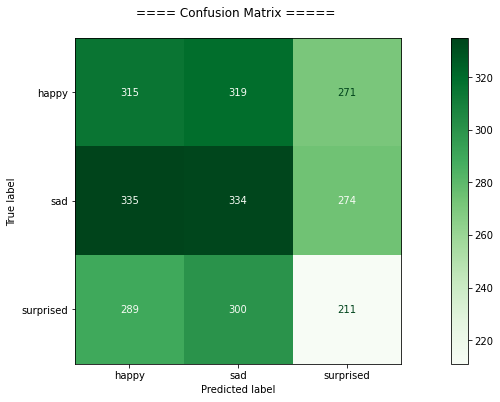


=============== Classification Report ================
              precision    recall  f1-score   support

       happy       0.34      0.35      0.34       905
         sad       0.35      0.35      0.35       943
   surprised       0.28      0.26      0.27       800

    accuracy                           0.32      2648
   macro avg       0.32      0.32      0.32      2648
weighted avg       0.32      0.32      0.32      2648



In [29]:
## Plot Confusion Matrix dan Classification Report

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

labels_list = list(train_generator.class_indices.keys())


fig, ax = plt.subplots(figsize=(18, 6))
cm = confusion_matrix(validation_generator.classes, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_list)
disp.plot(cmap=plt.cm.Greens, ax=ax)
plt.title("==== Confusion Matrix ===== \n")
plt.show()


print("\n=============== Classification Report ================")
print(classification_report(validation_generator.classes, y_pred, target_names=labels_list))

# Deployment

In [30]:
## save model keras *.h5

if os.path.exists('model')==False:
  os.mkdir('model')

model.save_weights("model/model_weights.h5")
model.save("model/model.h5")

In [31]:
import warnings
warnings.filterwarnings('ignore')

## Convert Model keras ke tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

## save model *.tflite
with open('model/model.tflite', 'wb') as f:
  f.write(tflite_model)

2022-10-14 07:41:19.240243: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-10-14 07:42:33.039282: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-14 07:42:33.039682: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2022-10-14 07:42:33.040664: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2022-10-14 07:42:33.042107: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-14 07:42:33.042508: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had ne